# Object Detection For Autonomous Driving

## Objective

The goal of this assignment is to fine-tune the YOLO object detection model on a subset of the KITTI dataset, widely used in autonomous driving research. The KITTI dataset provides annotated images for tasks like object detection, tracking, and segmentation, making it ideal for training models to detect objects such as cars, pedestrians, and cyclists.

By completing this assignment, you will gain hands-on experience in dataset preparation, annotation conversion, model training, and performance evaluation using metrics like mAP (mean Average Precision). Additionally, you will explore the trade-offs between speed and accuracy, crucial for real-time applications like autonomous driving.


## Introduction: Object Detection

Object detection is a fundamental task in computer vision that involves identifying and localizing objects within an image or video. 

The main techniques for object detection include traditional methods like sliding window and region-based approaches, as well as modern deep learning-based methods such as YOLO (You Only Look Once), SSD (Single Shot MultiBox Detector), and Faster R-CNN. These techniques leverage convolutional neural networks (CNNs) to extract features and predict bounding boxes and class labels for objects in real-time or near real-time. 

Widely used models for object detection include:
- **YOLO (You Only Look Once)**: Known for its speed and efficiency in real-time applications.
- **Faster R-CNN**: A two-stage detector that provides high accuracy but is slower compared to single-stage detectors.
- **SSD (Single Shot MultiBox Detector)**: Balances speed and accuracy, making it suitable for various applications.
- **RetinaNet**: Introduces the focal loss to address class imbalance in object detection.
- **EfficientDet**: A family of models that optimize both accuracy and efficiency using compound scaling.

In the context of autonomous vehicles, object detection plays a critical role in perceiving the environment, identifying obstacles, pedestrians, traffic signs, and other vehicles. This capability enables autonomous systems to make informed decisions, ensuring safety and efficiency in navigation and driving scenarios.

## YOLO

YOLO (You Only Look Once) is a state-of-the-art, real-time object detection system. Unlike traditional object detection methods that apply a classifier to different regions of an image, YOLO frames object detection as a single regression problem. It predicts bounding boxes and class probabilities directly from full images in one evaluation, making it extremely fast and efficient.

### Model

The YOLO model divides the input image into a grid, where each grid cell is responsible for predicting bounding boxes and their associated class probabilities. Key features of YOLO include:

- **Unified Architecture**: YOLO uses a single convolutional neural network (CNN) to predict multiple bounding boxes and class probabilities simultaneously.
- **Speed**: YOLO is optimized for real-time applications, capable of processing images at high frame rates.
- **Global Context**: By considering the entire image during training and inference, YOLO reduces false positives and improves detection accuracy.
- **Versions**: Over time, YOLO has evolved through multiple versions (e.g., YOLOv1 up to YOLOv11), each introducing architectural improvements, better loss functions, and enhanced performance.

YOLO is widely used in applications such as autonomous driving, surveillance, and robotics, where real-time object detection is critical.

For more details on YOLO, visit the [Ultralytics GitHub repository](https://github.com/ultralytics/ultralytics).

## Theory Questions


For the next questions, focus on the latest version of the model, YOLOv11

Briefly describe the architecture used in YOLOv11 and the different losses used during training.

ANS:

The following [picture](https://medium.com/@nikhil-rao-20/yolov11-explained-next-level-object-detection-with-enhanced-speed-and-accuracy-2dbe2d376f71) summarize the architecture of the YOLOv11

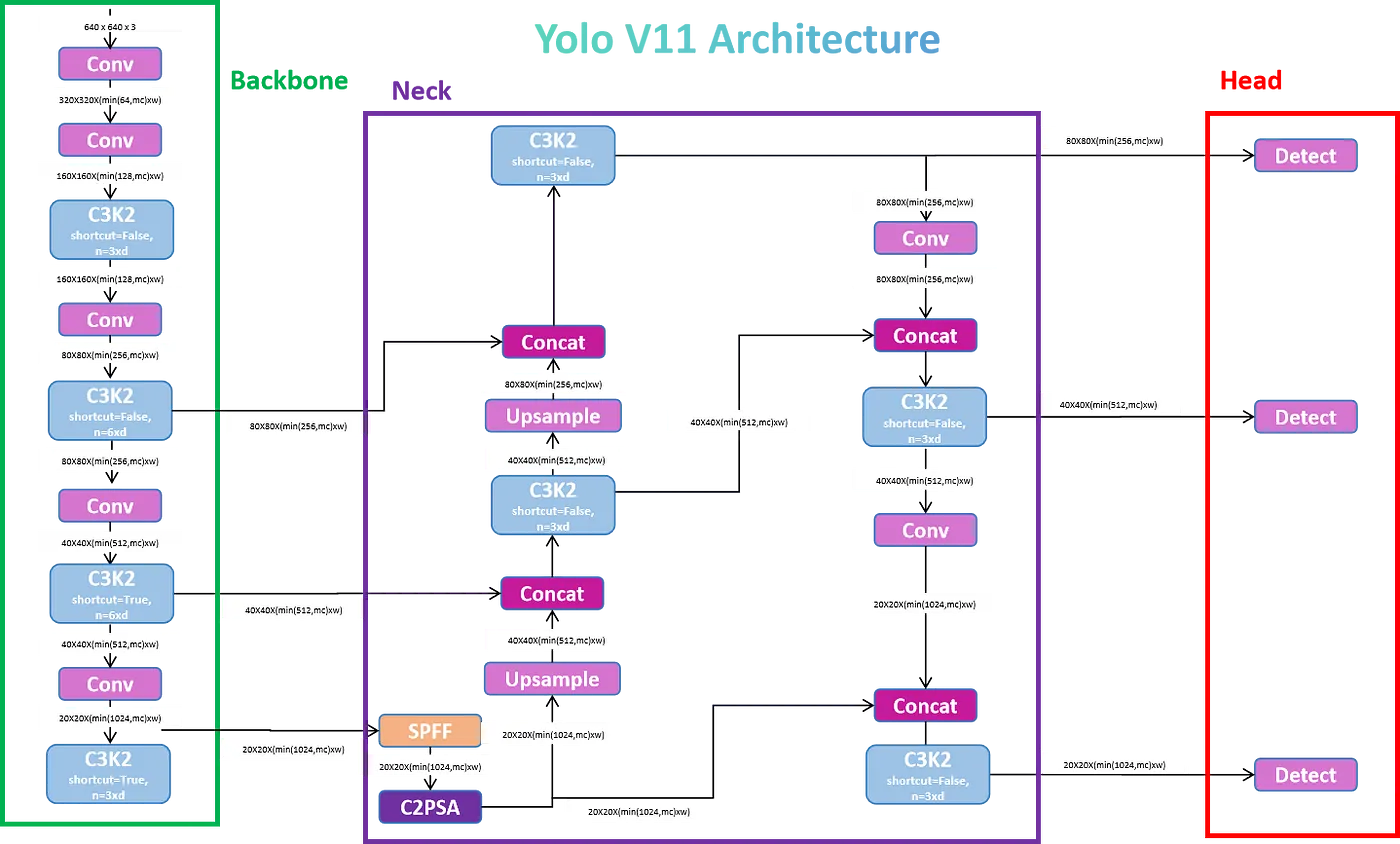

As it can be seen in the figure, there are three main sections that compose the architecture of the YOLOv11: the **Backbone**, the **Neck** and the **Head**.

The **Backbone** is the first section of the YOLOv11 and it is responsible for extracting features from the input images at *multiple scales*, an ability that previous versions of the model struggled with.

Following the official documentation, this new model is capable of a enhanced feature extraction (due to the change in the architecture of the backbone and neck stages), optimized speed efficiency, grater accuracy (with fewer parameters), supports a broad range of tasks and it is compatible with edge devices.

There are two main blocks inside the Backbone section: the *Conv Block* and the *C3K2 block*. The first one, *Conv Block* is a simple 2D convolutional layer, followed by a *Batch Normalization* and a *SiLU* activation function.
But at the heart of the Backbone stage, there is the *C3K2* block, that optimize the flow of information through the network by splitting the feature map and applying a series of smaller kernel convolution (which are faster computationally but still accurate). Furthermore, inside this block some skipping connections are present, which allows the model to learn in a better way, very similarly to the ResNet architecture.

Inside the Neck stage, instead, we find, in addition to some already described blocks, two new important block: the *SPFF Block* and the *C2PSA Block*.
The SPFF (Spatial Pyramid Pooling Fast) was designed to pool features from different regions of an image at varying scales. This allows the model to perform better in detecting small object. The idea behind this module is to combine the information extracted from the images at different resolution, using multiple max-pooling operations.

The most significant innovation in YOLOv11 is, after all, the C2PSA block (Cross Stage Partial with Spatial Attention), that allows the model to focus more on the important parts of the image, still by maintaining a balance between computational cost and detection accuracy. To identify this *regions of interest* this block apply spatial attention over the extracted features, potentially improving the detection accuracy for objects of varying sizes and positions.

The Head section of the YOLOv11 is responsible for generating the final predition in terms of object detection and classification. It outputs the detection boxes for three levels of granularity in the image, usign the feature maps generated by the backbone and neck.
Inside the Head section we find different blocks, like the C3k2, the Conv block and the some final convolutional layers and Detect layer, that reduce the feature to the required number of outputs for bounding box, object score (to indicate the presence of objects or not) coordinates and class predictions.


losses:
- box_loss
- cls_loss
- dfl_loss

Sources:
- [YOLOv11 Architecture Explained: Next-Level Object Detection with Enhanced Speed and Accuracy](https://medium.com/@nikhil-rao-20/yolov11-explained-next-level-object-detection-with-enhanced-speed-and-accuracy-2dbe2d376f71)
- [YOLOV11: AN OVERVIEW OF THE KEY ARCHITECTURAL ENHANCEMENTS](https://arxiv.org/pdf/2410.17725)
- [YOLOv11 Official Documentation](https://docs.ultralytics.com/models/yolo11/#performance-metrics)


What are the metrics used to assess YOLO's performance for object detection?

ANS:

## Code

In the next part of the assignment, you will load a YOLO model and fine-tune it on the provided subset of the KITTI dataset.
You will then visualize the training losses and evaluate the model by running inference to assess its performance.

In [1]:
# !pip install ultralytics opencv-python-headless -q

In [2]:
import os, cv2, glob, random, shutil, requests, zipfile
from ultralytics import YOLO

import matplotlib.pyplot as plt
import pandas as pd
import os

%matplotlib inline

from IPython.display import Image, display
import glob 

import yaml
import cv2
import matplotlib.pyplot as plt
import glob

In [3]:
# ---------------------------------------------
# STEP 1: Setup paths
# ---------------------------------------------
HOME = os.getcwd()
DATASET_PATH = os.path.join(HOME, "datasets", "kitti_subset")
IMAGES_PATH = os.path.join(DATASET_PATH, "images")
LABELS_PATH = os.path.join(DATASET_PATH, "labels")

TRAIN_IMG = os.path.join(IMAGES_PATH, "train")
VAL_IMG = os.path.join(IMAGES_PATH, "val")
TEST_IMG = os.path.join(IMAGES_PATH, "test")
TRAIN_LABEL = os.path.join(LABELS_PATH, "train")
VAL_LABEL = os.path.join(LABELS_PATH, "val")
TEST_LABEL = os.path.join(LABELS_PATH, "test")

for path in [TRAIN_IMG, VAL_IMG, TEST_IMG, TRAIN_LABEL, VAL_LABEL, TEST_LABEL]:
    os.makedirs(path, exist_ok=True)

# ---------------------------------------------
# STEP 2: Download and extract KITTI data
# ---------------------------------------------
KITTI_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_image_2.zip"
KITTI_LABELS_URL = "https://s3.eu-central-1.amazonaws.com/avg-kitti/data_object_label_2.zip"

def download_and_extract(url, extract_to):
    zip_path = os.path.join(HOME, url.split("/")[-1])
    if not os.path.exists(zip_path):
        print(f"Downloading {url}...")
        response = requests.get(url, stream=True)
        with open(zip_path, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print("Download complete.")

    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("Extraction complete.")

download_and_extract(KITTI_URL, IMAGES_PATH)
download_and_extract(KITTI_LABELS_URL, LABELS_PATH)

# ---------------------------------------------
# STEP 3: Convert KITTI annotations to YOLO
# ---------------------------------------------
CLASS_MAP = {"Car": 0, "Pedestrian": 1, "Cyclist": 2}

def convert_kitti_to_yolo(kitti_label_path, yolo_label_path, image_path):
    with open(kitti_label_path, "r") as file:
        lines = file.readlines()

    img = cv2.imread(image_path)
    if img is None:
        return
    height, width, _ = img.shape

    with open(yolo_label_path, "w") as yolo_file:
        for line in lines:
            elements = line.split()
            class_name = elements[0]
            if class_name not in CLASS_MAP:
                continue  # Skip irrelevant classes

            class_id = CLASS_MAP[class_name]
            x1, y1, x2, y2 = map(float, elements[4:8])

            # Convert to YOLO format
            center_x = ((x1 + x2) / 2) / width
            center_y = ((y1 + y2) / 2) / height
            bbox_width = (x2 - x1) / width
            bbox_height = (y2 - y1) / height

            yolo_file.write(f"{class_id} {center_x:.6f} {center_y:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")

# ---------------------------------------------
# STEP 4: Prepare dataset (subset, split, convert)
# ---------------------------------------------
all_images = sorted(glob.glob(os.path.join(IMAGES_PATH, "training", "image_2", "*.png")))
all_labels = sorted(glob.glob(os.path.join(LABELS_PATH, "training", "label_2", "*.txt")))

paired_data = list(zip(all_images, all_labels))
random.seed(42)
random.shuffle(paired_data)

# Keep small subset (e.g., 300 images total)
subset_data = paired_data[:300]
train_size = int(0.8 * len(subset_data))
val_size = int(0.1 * len(subset_data))

train_data = subset_data[:train_size]
val_data = subset_data[train_size:train_size + val_size]
test_data = subset_data[train_size + val_size:]

def move_and_convert_files(data, img_dest, lbl_dest):
    for img_path, lbl_path in data:
        new_img_path = os.path.join(img_dest, os.path.basename(img_path))
        new_lbl_path = os.path.join(lbl_dest, os.path.basename(lbl_path))
        shutil.copy2(img_path, new_img_path)
        convert_kitti_to_yolo(lbl_path, new_lbl_path, new_img_path)

move_and_convert_files(train_data, TRAIN_IMG, TRAIN_LABEL)
move_and_convert_files(val_data, VAL_IMG, VAL_LABEL)
move_and_convert_files(test_data, TEST_IMG, TEST_LABEL)


# ---------------------------------------------
# STEP 5: Create data.yaml
# ---------------------------------------------
data_yaml = f"""
path: {DATASET_PATH}
train: images/train
val: images/val
test: images/test

nc: 3
names: ['Car', 'Pedestrian', 'Cyclist']
"""

with open(os.path.join(DATASET_PATH, "data.yaml"), "w") as f:
    f.write(data_yaml)



Extracting /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/data_object_image_2.zip...
Extraction complete.
Extracting /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/data_object_label_2.zip...
Extraction complete.


In [8]:
# ---------------------------------------------
# STEP 6: Fine-tune YOLOv11 model
# ---------------------------------------------
#TO-DO: Add the code to fine-tune the YOLOv5 model
# model = YOLO("yolo11n.pt")

# # Train the model
# model.train(data=os.path.join(DATASET_PATH, "data.yaml"), epochs=20, imgsz=640, device="0", batch=6)

# from ultralytics import YOLO
# import os

# # Set up paths
# DATASET_PATH = "/your/full/path/to/dataset"
# DATA_YAML = os.path.join(DATASET_PATH, "data.yaml")

# Load your pretrained model
model = YOLO("yolo11m.pt")  # Replace with your path if needed

# Fine-tune with custom training settings
model.train(
    data=os.path.join(DATASET_PATH, "data.yaml"),
    epochs=50,
    imgsz=640,
    device=0,                      # or "cpu" if no GPU
    batch=8,
    lr0=1e-4,                      # initial learning rate
    lrf=0.1,                       # final learning rate fraction
    box=7.5,                       # box loss gain
    cls=0.5,                       # class loss gain
    dfl=1.5,                       # dfl loss gain
    hsv_h=0.030, hsv_s=0.8, hsv_v=0.5,  # color augmentation
    degrees=1,                  # rotation
    translate=0.1,                # translation
    scale=0.5,                    # scale jitter
    shear=0.2,
    perspective=0.0005,
    flipud=0.2, fliplr=0.5,       # flipping
    mosaic=1.0, mixup=0.1,        # advanced augmentations
    patience=20,                  # early stopping patience
    project="runs",               # output directory
    name="yolo11-finetune_2",
    exist_ok=True
)


New https://pypi.org/project/ultralytics/8.3.105 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.97 🚀 Python-3.13.2 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7817MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=/home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/data.yaml, epochs=50, time=None, patience=20, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=runs, name=yolo11-finetune_2, exist_ok=True, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, vis

train: Scanning /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/labels/train.cache... 240 images, 0 backgrounds, 0 corrupt: 100%|██████████| 240/240 [00:00<?, ?it/s]
val: Scanning /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/labels/val.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to runs/yolo11-finetune_2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.0001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/yolo11-finetune_2
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.79G      1.663      2.183       1.29         93        640: 100%|██████████| 30/30 [00:15<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.94it/s]

                   all         30        128      0.485      0.566      0.441      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      4.81G      1.625      1.425      1.309         62        640: 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         30        128       0.62      0.346      0.312      0.168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.81G      1.695      1.457      1.351         50        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128       0.94      0.213      0.348      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      4.81G      1.692      1.511      1.382         92        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         30        128      0.665       0.36      0.374      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      4.81G      1.711      1.427      1.374         68        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         30        128      0.439      0.303      0.268      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      4.83G      1.672      1.344      1.373        105        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         30        128      0.408        0.5      0.445        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50       4.9G      1.608      1.159      1.289        106        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         30        128      0.717      0.411      0.426      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      4.91G      1.592      1.226      1.291        118        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.95it/s]

                   all         30        128      0.637      0.606      0.591      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      4.91G      1.561      1.206      1.303         65        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         30        128      0.607      0.569      0.566      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      4.91G      1.556      1.192       1.28         69        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         30        128      0.457       0.54      0.541        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      4.91G      1.541      1.169      1.265         91        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         30        128       0.82      0.609      0.621      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      4.91G       1.56      1.177      1.283         46        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         30        128      0.813      0.456      0.594      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      4.91G      1.485      1.103      1.253         80        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         30        128      0.764      0.593      0.628      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      4.91G      1.522      1.098      1.259         84        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.98it/s]

                   all         30        128      0.733       0.49      0.532      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      4.91G      1.473      1.076      1.232         75        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         30        128      0.801      0.539      0.597      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      4.91G      1.463      1.048      1.227        145        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.99it/s]

                   all         30        128       0.64      0.608      0.623       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      4.91G      1.472      1.037      1.222         85        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         30        128      0.806      0.613      0.692      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      4.91G      1.401     0.9902      1.202         89        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         30        128       0.73      0.706       0.72      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      4.91G      1.409      1.016      1.214        125        640: 100%|██████████| 30/30 [00:15<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         30        128      0.662      0.641      0.663      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      4.91G      1.391     0.9594      1.195         91        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         30        128      0.725       0.57      0.605      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      4.91G      1.383     0.9309      1.187        125        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         30        128      0.729      0.623      0.717      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      4.91G      1.376     0.9259      1.187        119        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         30        128      0.736      0.608      0.634        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      4.91G      1.359     0.9229       1.17        112        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.784      0.614      0.604      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      4.91G      1.344     0.9326      1.172         65        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         30        128      0.894      0.583      0.648      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      4.91G      1.352     0.9488      1.182         50        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         30        128      0.836      0.573      0.639      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      4.91G      1.385     0.9435      1.198        110        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.00it/s]

                   all         30        128      0.892      0.611      0.661      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.91G      1.342     0.9058      1.166        119        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.805      0.594      0.704      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.91G      1.335       0.89      1.161         90        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         30        128      0.873      0.589        0.7      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.91G      1.318      0.862       1.14         66        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.09it/s]

                   all         30        128      0.749      0.686      0.755      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.91G      1.309     0.8831      1.162         61        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.01it/s]

                   all         30        128      0.897      0.562      0.707      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.91G      1.264     0.8404      1.127         82        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.911      0.589      0.719      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.91G      1.323     0.8959      1.126         62        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         30        128      0.852      0.683      0.764      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      4.91G      1.253     0.8459      1.136         96        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128       0.87      0.586       0.75      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.91G      1.287     0.8519      1.149         88        640: 100%|██████████| 30/30 [00:15<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         30        128      0.739      0.801      0.779      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.91G      1.248     0.8191      1.112        130        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         30        128      0.768      0.789      0.811      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.91G      1.237     0.8163      1.123         66        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         30        128      0.733      0.702       0.77      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.91G      1.259     0.8373      1.121         58        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         30        128      0.864      0.637      0.799      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.91G      1.244     0.8105      1.111         95        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.81it/s]

                   all         30        128      0.828      0.705      0.771      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      4.91G      1.163     0.7528      1.081        103        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.797      0.781      0.807      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.91G      1.212      0.796      1.112         99        640: 100%|██████████| 30/30 [00:15<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.744      0.802      0.799      0.513


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.91G      1.076      0.745      1.038         44        640: 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.05it/s]

                   all         30        128      0.855      0.578      0.752      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.91G      1.109     0.7472      1.067         38        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.718      0.683      0.705      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.91G      1.061     0.7229      1.033         26        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         30        128      0.674      0.707      0.706      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.91G      1.097     0.6896      1.037         34        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         30        128      0.796      0.589      0.692      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.91G      1.078      0.699      1.047         29        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.10it/s]

                   all         30        128      0.664      0.835      0.813      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      4.91G      1.051     0.6694      1.026         46        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         30        128      0.677      0.818      0.774      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.91G      1.064     0.6795      1.026         30        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

                   all         30        128      0.912       0.62      0.774      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.91G      1.036     0.6402       1.02         43        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.03it/s]

                   all         30        128      0.928      0.748      0.841      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.91G      1.017      0.642      1.006         32        640: 100%|██████████| 30/30 [00:15<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.08it/s]

                   all         30        128      0.855      0.846      0.856      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.91G      1.011     0.6358      1.018         45        640: 100%|██████████| 30/30 [00:15<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         30        128      0.813      0.823      0.809      0.516



50 epochs completed in 0.224 hours.
Optimizer stripped from runs/yolo11-finetune_2/weights/last.pt, 40.5MB
Optimizer stripped from runs/yolo11-finetune_2/weights/best.pt, 40.5MB

Validating runs/yolo11-finetune_2/weights/best.pt...
Ultralytics 8.3.97 🚀 Python-3.13.2 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Laptop GPU, 7817MiB)
YOLO11m summary (fused): 125 layers, 20,032,345 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.64it/s]


                   all         30        128      0.768      0.789      0.811      0.519
                   Car         26        108      0.894      0.806      0.872        0.6
            Pedestrian          7         16      0.629      0.562      0.666      0.408
               Cyclist          3          4      0.782          1      0.895      0.549
Speed: 0.1ms preprocess, 7.7ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/yolo11-finetune_2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f11cc642ba0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04

# Inference

After training, visualize the losses andmetrics calculated on the validation set during training.

Additionally, make sure you visualize the confusion matrix to see per-class errors.

For qualitative analysis, run inference on the model, visualise the bouding boxes and visually assess it.

In [5]:
# -------- VISUALIZE TRAINING LOSSES AND METRICS --------
#TO-DO: Add the code to visualize the training losses and metrics

In [6]:
# ------ VISUALIZE CONFUSION MATRIX --------
#TO-DO: Add the code to visualize the confusion matrix


image 1/30 /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/images/test/000735.png: 224x640 1 person, 7 cars, 1 motorcycle, 46.9ms
image 2/30 /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/images/test/000797.png: 224x640 1 person, 5 bicycles, 1 car, 1 truck, 44.5ms
image 3/30 /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/images/test/001002.png: 224x640 5 cars, 44.5ms
image 4/30 /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/images/test/001068.png: 224x640 9 persons, 6 bicycles, 2 cars, 1 handbag, 44.5ms
image 5/30 /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/datasets/kitti_subset/images/test/001756.png: 224x640 3 cars, 44.5ms
image 6/30 /home/filippoquadri/Nextcloud/EPFL/MA4/Deep Learning/DLAV-2025/graded_homework/hw2/da

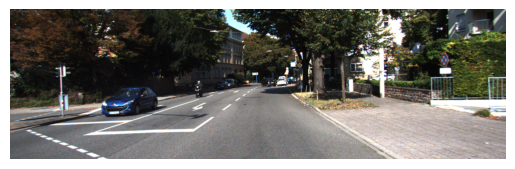

Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.8493], device='cuda:0'), BBox: tensor([[1.2407e-01, 2.4001e+02, 7.5445e+01, 3.1949e+02]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.6909], device='cuda:0'), BBox: tensor([[267.9879, 217.1399, 302.9803, 258.9694]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.5799], device='cuda:0'), BBox: tensor([[695.1878, 183.8342, 713.5923, 231.5260]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.5570], device='cuda:0'), BBox: tensor([[303.8789, 192.9793, 427.2477, 281.7540]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.5480], device='cuda:0'), BBox: tensor([[1198.7863,  193.5588, 1241.3887,  225.9767]], device='cuda:0')
Class: tensor([7.], device='cuda:0'), Confidence: tensor([0.5235], device='cuda:0'), BBox: tensor([[303.9008, 192.7001, 427.8955, 281.5476]], device='cuda:0')
Class: tensor([1.], device='cuda:0

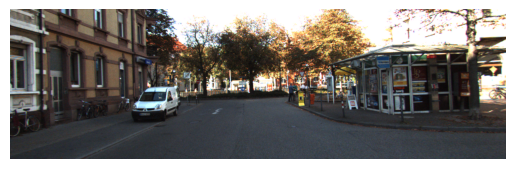

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8820], device='cuda:0'), BBox: tensor([[395.2901, 188.4166, 502.4283, 252.9514]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8305], device='cuda:0'), BBox: tensor([[606.2780, 177.5889, 647.8138, 214.2892]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8240], device='cuda:0'), BBox: tensor([[479.0565, 179.9605, 528.4808, 227.1504]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8002], device='cuda:0'), BBox: tensor([[520.1318, 176.8665, 552.5406, 208.5692]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.5450], device='cuda:0'), BBox: tensor([[544.9372, 170.0000, 568.7383, 193.1195]], device='cuda:0')


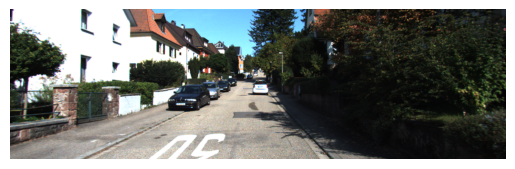

Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.9215], device='cuda:0'), BBox: tensor([[ 909.8336,  206.8325, 1105.7939,  372.9157]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8882], device='cuda:0'), BBox: tensor([[659.8162, 170.9185, 724.6818, 343.8483]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8841], device='cuda:0'), BBox: tensor([[714.7255, 163.4581, 792.8909, 341.2181]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8659], device='cuda:0'), BBox: tensor([[250.6376, 159.8120, 339.9548, 352.4868]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.8544], device='cuda:0'), BBox: tensor([[245.6613, 242.8062, 347.7747, 372.6370]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8278], device='cuda:0'), BBox: tensor([[203.6846, 162.2055, 268.3630, 340.2848]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Conf

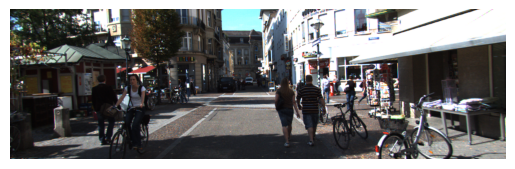

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8728], device='cuda:0'), BBox: tensor([[441.8459, 188.0163, 522.1618, 246.7291]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8358], device='cuda:0'), BBox: tensor([[551.2703, 181.4314, 578.3274, 201.8980]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.2565], device='cuda:0'), BBox: tensor([[586.7975, 178.6264, 600.8771, 187.0378]], device='cuda:0')


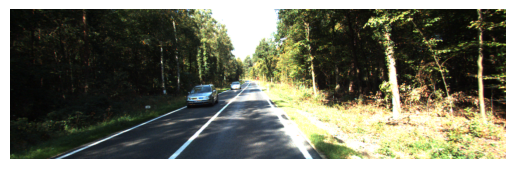

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8570], device='cuda:0'), BBox: tensor([[2.4564e-01, 1.7702e+02, 1.2445e+02, 3.1402e+02]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8138], device='cuda:0'), BBox: tensor([[218.9992, 180.2762, 346.1169, 248.9210]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7983], device='cuda:0'), BBox: tensor([[ 77.7442, 187.3761, 253.2812, 286.2388]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7679], device='cuda:0'), BBox: tensor([[651.2716, 171.3673, 674.9633, 191.8639]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.6736], device='cuda:0'), BBox: tensor([[456.7625, 179.0299, 497.3274, 206.0404]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.6735], device='cuda:0'), BBox: tensor([[599.9072, 173.1072, 621.9337, 186.9619]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), 

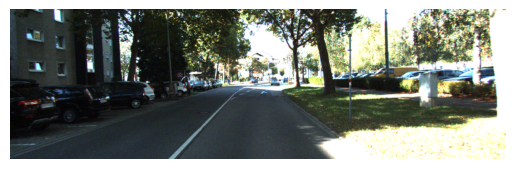

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9281], device='cuda:0'), BBox: tensor([[ 924.6879,  173.1982, 1240.1499,  360.4378]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8980], device='cuda:0'), BBox: tensor([[717.3301, 173.9280, 863.1398, 241.2150]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8394], device='cuda:0'), BBox: tensor([[589.0367, 172.5930, 637.3256, 219.7256]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8080], device='cuda:0'), BBox: tensor([[431.3058, 184.4560, 476.1024, 215.9486]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7877], device='cuda:0'), BBox: tensor([[676.1119, 175.7174, 733.3881, 219.2723]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7441], device='cuda:0'), BBox: tensor([[383.7057, 179.3279, 409.5255, 200.2837]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Conf

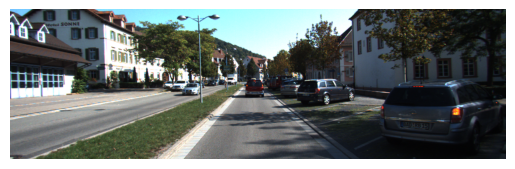

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7771], device='cuda:0'), BBox: tensor([[446.0492, 187.5467, 531.4557, 248.3538]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7142], device='cuda:0'), BBox: tensor([[  0.5852, 160.8360, 208.2758, 370.0665]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7006], device='cuda:0'), BBox: tensor([[538.0065, 202.5566, 560.1716, 222.7631]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.4384], device='cuda:0'), BBox: tensor([[596.8823, 200.0005, 620.3764, 221.2773]], device='cuda:0')


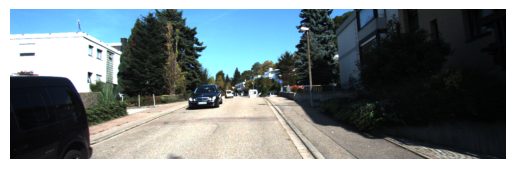

Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.8301], device='cuda:0'), BBox: tensor([[  0.4476, 205.7433, 130.6339, 305.2485]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8114], device='cuda:0'), BBox: tensor([[ 967.7144,  161.2592, 1034.1564,  270.1716]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7762], device='cuda:0'), BBox: tensor([[506.0287, 172.9167, 528.1471, 237.9505]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7397], device='cuda:0'), BBox: tensor([[483.6925, 170.3131, 506.7969, 237.7710]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.6210], device='cuda:0'), BBox: tensor([[652.0377, 165.0555, 669.2515, 215.5243]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.6050], device='cuda:0'), BBox: tensor([[676.2332, 164.2691, 692.7295, 214.4423]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Conf

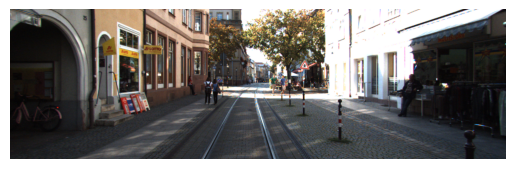

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9303], device='cuda:0'), BBox: tensor([[727.8546, 188.0674, 877.0727, 290.8354]], device='cuda:0')
Class: tensor([7.], device='cuda:0'), Confidence: tensor([0.9232], device='cuda:0'), BBox: tensor([[678.0739,  96.6123, 810.4337, 229.5762]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9168], device='cuda:0'), BBox: tensor([[ 92.5193, 188.8166, 290.0826, 310.4402]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8706], device='cuda:0'), BBox: tensor([[590.4152, 175.4630, 644.1035, 219.4926]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8619], device='cuda:0'), BBox: tensor([[496.1487, 182.9215, 566.6909, 235.7399]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8356], device='cuda:0'), BBox: tensor([[183.1156, 175.3314, 379.9069, 269.7741]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confiden

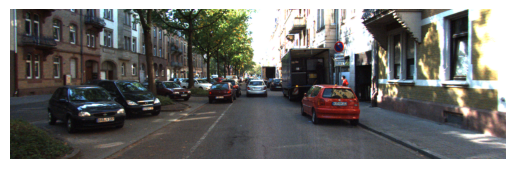

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7892], device='cuda:0'), BBox: tensor([[589.8118, 179.6949, 638.0574, 218.3872]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7246], device='cuda:0'), BBox: tensor([[488.9352, 171.9738, 544.6589, 209.8459]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.2750], device='cuda:0'), BBox: tensor([[544.1114, 175.7117, 557.3528, 198.9168]], device='cuda:0')


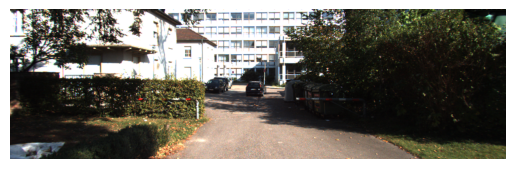

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.6902], device='cuda:0'), BBox: tensor([[537.8980, 174.0800, 557.1010, 189.0504]], device='cuda:0')


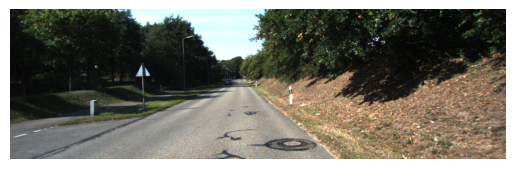

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9264], device='cuda:0'), BBox: tensor([[270.9276, 192.6794, 498.6602, 321.8010]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8867], device='cuda:0'), BBox: tensor([[481.5567, 183.8242, 576.1565, 261.1468]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8503], device='cuda:0'), BBox: tensor([[572.5840, 183.8073, 645.6041, 232.1642]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.6321], device='cuda:0'), BBox: tensor([[788.0048, 163.3347, 821.2719, 190.0218]], device='cuda:0')


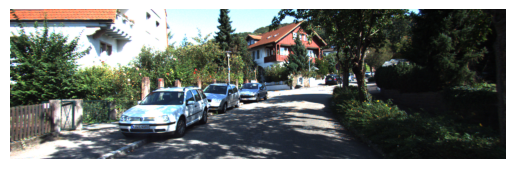

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8876], device='cuda:0'), BBox: tensor([[189.4733, 190.5436, 269.6312, 230.9627]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8548], device='cuda:0'), BBox: tensor([[6.5423e-02, 2.0469e+02, 4.6136e+01, 2.5107e+02]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7790], device='cuda:0'), BBox: tensor([[391.5759, 186.4297, 425.4890, 203.5634]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.5846], device='cuda:0'), BBox: tensor([[451.8471, 181.1011, 479.3097, 195.8550]], device='cuda:0')


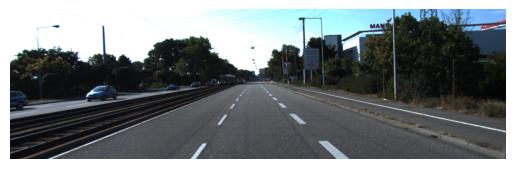

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9485], device='cuda:0'), BBox: tensor([[ 876.7615,  199.2670, 1241.2737,  370.3253]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8477], device='cuda:0'), BBox: tensor([[226.1158, 180.8873, 305.1911, 212.8029]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8387], device='cuda:0'), BBox: tensor([[644.1784, 169.8256, 725.1353, 203.1441]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8289], device='cuda:0'), BBox: tensor([[850.5494, 167.4220, 946.8847, 197.5486]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7868], device='cuda:0'), BBox: tensor([[504.8539, 176.4301, 567.7013, 204.4617]], device='cuda:0')
Class: tensor([9.], device='cuda:0'), Confidence: tensor([0.6855], device='cuda:0'), BBox: tensor([[974.1070,  87.8423, 990.9615, 135.3996]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Conf

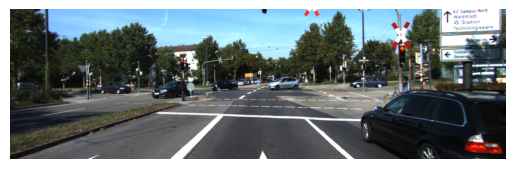

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8431], device='cuda:0'), BBox: tensor([[306.6587, 182.4134, 373.6899, 220.2842]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.5338], device='cuda:0'), BBox: tensor([[510.8919, 179.5061, 528.2045, 189.8882]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.4436], device='cuda:0'), BBox: tensor([[445.9521, 181.8622, 467.1998, 194.2993]], device='cuda:0')
Class: tensor([5.], device='cuda:0'), Confidence: tensor([0.4307], device='cuda:0'), BBox: tensor([[600.0494, 155.8952, 640.6298, 199.6271]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.3683], device='cuda:0'), BBox: tensor([[490.3237, 179.7231, 508.7123, 193.3283]], device='cuda:0')


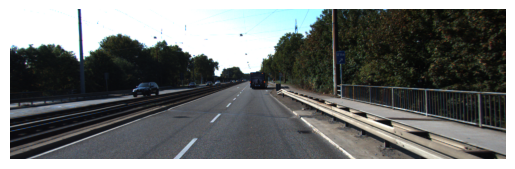

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9059], device='cuda:0'), BBox: tensor([[277.0867, 186.0099, 423.0148, 264.4944]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.6925], device='cuda:0'), BBox: tensor([[593.6243, 172.3372, 616.7315, 187.9923]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.5456], device='cuda:0'), BBox: tensor([[624.6058, 169.9344, 644.3853, 187.3127]], device='cuda:0')


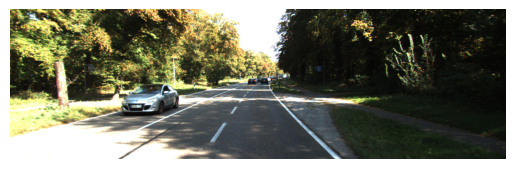

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9299], device='cuda:0'), BBox: tensor([[  0.5276, 237.9213, 203.4922, 372.2555]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9065], device='cuda:0'), BBox: tensor([[793.8562, 194.4405, 956.2754, 304.0364]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8914], device='cuda:0'), BBox: tensor([[ 938.8613,  200.0645, 1074.5735,  373.0966]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8125], device='cuda:0'), BBox: tensor([[ 933.4436,  199.8651, 1241.0972,  371.6953]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7951], device='cuda:0'), BBox: tensor([[739.4811, 192.4398, 817.3425, 255.1554]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7293], device='cuda:0'), BBox: tensor([[557.1102, 178.6731, 599.3830, 210.9957]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), 

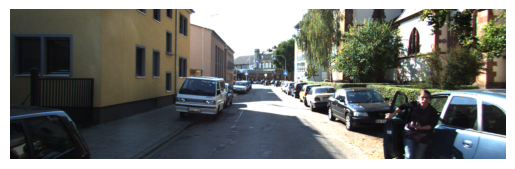

Class: tensor([6.], device='cuda:0'), Confidence: tensor([0.8901], device='cuda:0'), BBox: tensor([[9.8934e+02, 1.0968e+00, 1.2411e+03, 3.1036e+02]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8638], device='cuda:0'), BBox: tensor([[576.2711, 176.6660, 636.3483, 230.8700]], device='cuda:0')


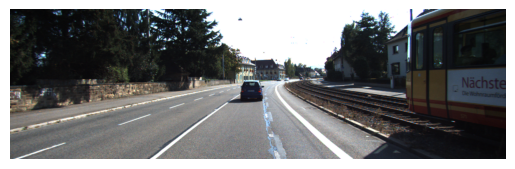

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9232], device='cuda:0'), BBox: tensor([[  0.0000, 190.2329, 297.9338, 338.2881]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9130], device='cuda:0'), BBox: tensor([[726.4443, 192.4838, 900.3994, 296.2743]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8440], device='cuda:0'), BBox: tensor([[194.2907, 180.9111, 399.1917, 259.8509]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8351], device='cuda:0'), BBox: tensor([[308.8507, 177.4021, 433.5580, 233.9319]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8294], device='cuda:0'), BBox: tensor([[512.9896, 177.6353, 566.1893, 219.1435]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8139], device='cuda:0'), BBox: tensor([[428.4727, 176.2468, 511.7004, 206.7642]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confiden

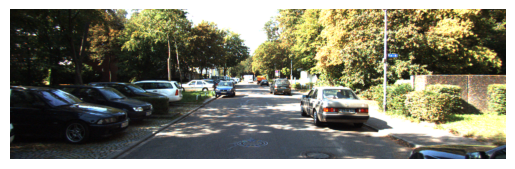

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9385], device='cuda:0'), BBox: tensor([[1022.4843,  185.8961, 1241.6482,  372.8907]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9092], device='cuda:0'), BBox: tensor([[168.2649, 182.3177, 410.4600, 262.2808]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8849], device='cuda:0'), BBox: tensor([[2.2700e-01, 2.1231e+02, 1.3734e+02, 3.6142e+02]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8775], device='cuda:0'), BBox: tensor([[  0.0000, 203.9495, 215.9457, 310.2586]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8571], device='cuda:0'), BBox: tensor([[665.1769, 186.5484, 737.5960, 236.0387]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7641], device='cuda:0'), BBox: tensor([[553.7305, 174.8238, 581.7297, 200.7430]], device='cuda:0')
Class: tensor([2.], device='cuda:0

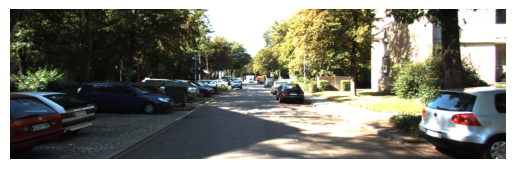

Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8495], device='cuda:0'), BBox: tensor([[1071.0327,  157.9332, 1181.3595,  349.0697]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7974], device='cuda:0'), BBox: tensor([[174.2800, 166.6034, 205.6118, 264.6966]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7713], device='cuda:0'), BBox: tensor([[832.1292, 188.4652, 894.6869, 254.4277]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7370], device='cuda:0'), BBox: tensor([[798.3328, 158.9927, 834.3021, 279.2716]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.6916], device='cuda:0'), BBox: tensor([[251.7174, 166.2669, 283.8502, 264.4768]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.6688], device='cuda:0'), BBox: tensor([[1081.9924,  163.9417, 1119.1379,  289.7952]], device='cuda:0')
Class: tensor([26.], device='cuda:0'),

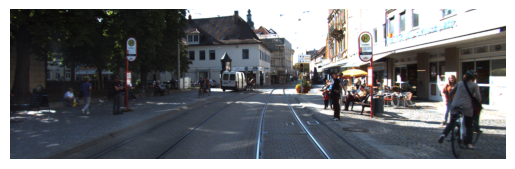

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9384], device='cuda:0'), BBox: tensor([[  0.0000, 166.7734, 352.3264, 305.4358]], device='cuda:0')
Class: tensor([7.], device='cuda:0'), Confidence: tensor([0.8854], device='cuda:0'), BBox: tensor([[657.4067, 142.1882, 730.7396, 222.4348]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8124], device='cuda:0'), BBox: tensor([[701.0599, 184.9906, 743.5432, 258.2841]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7556], device='cuda:0'), BBox: tensor([[353.8591, 174.4178, 461.5528, 221.8365]], device='cuda:0')
Class: tensor([5.], device='cuda:0'), Confidence: tensor([0.7271], device='cuda:0'), BBox: tensor([[ 733.1940,   75.3418, 1117.7897,  348.5534]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7134], device='cuda:0'), BBox: tensor([[637.0099, 176.3546, 658.9885, 201.8058]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Conf

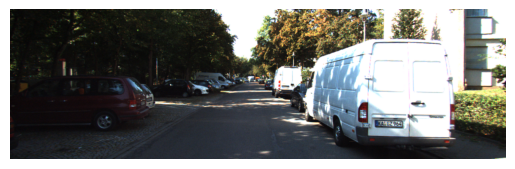

Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8725], device='cuda:0'), BBox: tensor([[772.1163, 148.9180, 814.4084, 258.6674]], device='cuda:0')
Class: tensor([3.], device='cuda:0'), Confidence: tensor([0.7956], device='cuda:0'), BBox: tensor([[273.7457, 189.9779, 338.9824, 247.4310]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.7775], device='cuda:0'), BBox: tensor([[1059.3094,  178.9412, 1191.4324,  266.8008]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7663], device='cuda:0'), BBox: tensor([[892.2837, 138.1753, 944.7261, 229.9901]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7570], device='cuda:0'), BBox: tensor([[723.3676, 158.3045, 745.5406, 231.4937]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.7207], device='cuda:0'), BBox: tensor([[ 970.6780,  176.5883, 1034.6814,  250.7843]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), 

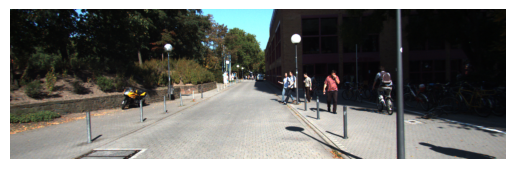

Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8150], device='cuda:0'), BBox: tensor([[ 81.3767, 148.4713, 106.8518, 220.7921]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.7978], device='cuda:0'), BBox: tensor([[119.1313, 151.6568, 145.8945, 221.7161]], device='cuda:0')
Class: tensor([1.], device='cuda:0'), Confidence: tensor([0.7625], device='cuda:0'), BBox: tensor([[1022.3403,  200.4306, 1098.2542,  247.5562]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7610], device='cuda:0'), BBox: tensor([[1073.8981,  187.0092, 1153.2333,  222.3836]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7113], device='cuda:0'), BBox: tensor([[1131.2896,  187.7233, 1200.0167,  223.2815]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.6206], device='cuda:0'), BBox: tensor([[1041.2311,  179.5286, 1080.7665,  236.9765]], device='cuda:0')
Class: tensor([1.], device='cu

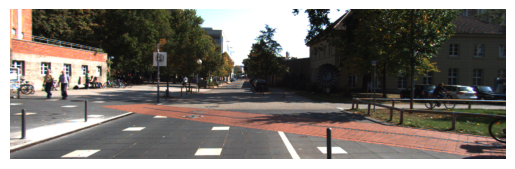

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7978], device='cuda:0'), BBox: tensor([[699.8170, 177.0617, 775.3400, 232.8204]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7154], device='cuda:0'), BBox: tensor([[769.7939, 169.0799, 809.8092, 198.9552]], device='cuda:0')
Class: tensor([7.], device='cuda:0'), Confidence: tensor([0.6325], device='cuda:0'), BBox: tensor([[ 951.5028,  157.1424, 1118.2854,  259.5649]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.6233], device='cuda:0'), BBox: tensor([[882.5173, 158.5650, 926.4014, 197.9365]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.4950], device='cuda:0'), BBox: tensor([[ 951.7281,  157.2066, 1117.9718,  259.5759]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.4434], device='cuda:0'), BBox: tensor([[800.4520, 166.3959, 822.0540, 184.0465]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), 

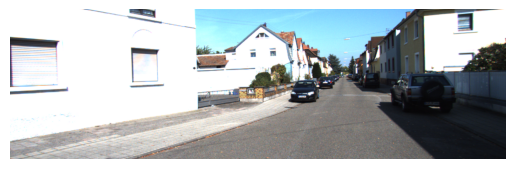

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9459], device='cuda:0'), BBox: tensor([[ 896.6734,  183.2418, 1241.1919,  370.6743]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8665], device='cuda:0'), BBox: tensor([[494.4196, 186.5522, 578.9543, 241.3203]], device='cuda:0')
Class: tensor([3.], device='cuda:0'), Confidence: tensor([0.8193], device='cuda:0'), BBox: tensor([[299.3508, 192.4536, 403.6317, 257.9181]], device='cuda:0')
Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.8044], device='cuda:0'), BBox: tensor([[845.0491, 153.9072, 881.6417, 263.9729]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7739], device='cuda:0'), BBox: tensor([[556.5206, 179.7195, 594.8235, 217.6813]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7493], device='cuda:0'), BBox: tensor([[671.7941, 169.8406, 695.3959, 195.4908]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Conf

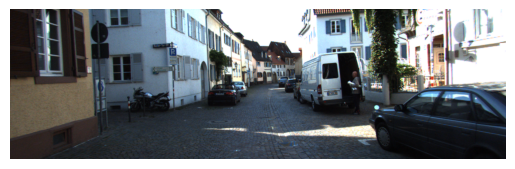

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8881], device='cuda:0'), BBox: tensor([[ 45.7793, 196.6847, 189.6265, 261.5579]], device='cuda:0')
Class: tensor([7.], device='cuda:0'), Confidence: tensor([0.8618], device='cuda:0'), BBox: tensor([[218.1152, 161.3074, 297.0507, 224.8488]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7827], device='cuda:0'), BBox: tensor([[597.7355, 173.5143, 629.1832, 203.4140]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.5982], device='cuda:0'), BBox: tensor([[447.3422, 175.6679, 477.2834, 198.5786]], device='cuda:0')
Class: tensor([5.], device='cuda:0'), Confidence: tensor([0.4136], device='cuda:0'), BBox: tensor([[645.7096, 160.9224, 674.5674, 191.9082]], device='cuda:0')
Class: tensor([6.], device='cuda:0'), Confidence: tensor([0.3011], device='cuda:0'), BBox: tensor([[550.5730, 164.1345, 579.2316, 189.1075]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confiden

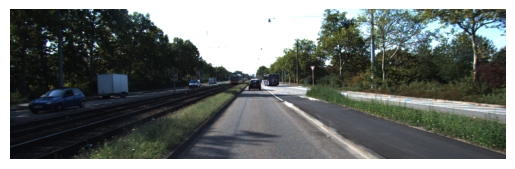

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9001], device='cuda:0'), BBox: tensor([[348.5347, 178.4514, 466.9832, 270.0870]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7813], device='cuda:0'), BBox: tensor([[449.5223, 179.8042, 482.2092, 217.1172]], device='cuda:0')


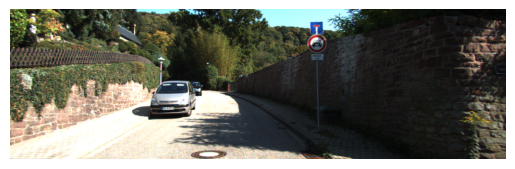

Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9417], device='cuda:0'), BBox: tensor([[ 799.7502,  193.0388, 1173.1639,  372.6181]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.9371], device='cuda:0'), BBox: tensor([[190.9007, 182.8961, 408.8558, 309.3886]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8601], device='cuda:0'), BBox: tensor([[433.0782, 182.7272, 499.5311, 229.7200]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.8020], device='cuda:0'), BBox: tensor([[667.4085, 175.2043, 734.7299, 231.4263]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.7304], device='cuda:0'), BBox: tensor([[500.2583, 179.2494, 537.1837, 209.0367]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Confidence: tensor([0.4722], device='cuda:0'), BBox: tensor([[536.6067, 180.2130, 561.0168, 198.0358]], device='cuda:0')
Class: tensor([2.], device='cuda:0'), Conf

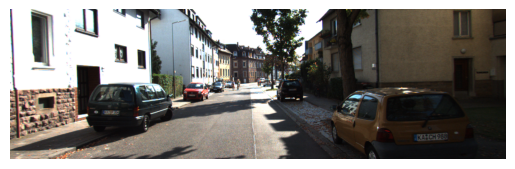

In [7]:
# -------- RUN INFERENCE AND PLOT SAMPLE OUTPUTS --------
#TO-DO: Add the code to run inference and visualize the outputs results
model = YOLO("yolo11x.pt")
results = model.predict(source=TEST_IMG, conf=0.25, save=True)
for result in results:
    for box in result.boxes:
        print(f"Class: {box.cls}, Confidence: {box.conf}, BBox: {box.xyxy}")
# Display the results
for result in results:
    for box in result.boxes:
        print(f"Class: {box.cls}, Confidence: {box.conf}, BBox: {box.xyxy}")
    img = result.orig_img
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
# ---------------------------------------------
# STEP 7: Evaluate the model

## Question

Comment on the performance of the model based on the visualizations you made and discuss the inference speed versus performance for YOLO on the driving datasets. Do you think we can use YOLO online on autonomous cars? 

## Ans